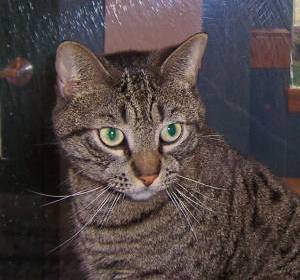

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt

mobile = tf.keras.applications.mobilenet.MobileNet()

def prepare_image(file):
    img_path = 'data/MobileNet-samples/'
    img = image.load_img(img_path + file, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

from IPython.display import Image
Image(filename='data/MobileNet-samples/cat.1.jpg', width=300, height=200)


In [2]:
preprocessed_image = prepare_image('cat.1.jpg')
predictions = mobile.predict(preprocessed_image)
result = imagenet_utils.decode_predictions(predictions)
print(result)


[[('n02123045', 'tabby', 0.74364287), ('n02124075', 'Egyptian_cat', 0.1313716), ('n02123159', 'tiger_cat', 0.12038975), ('n02127052', 'lynx', 0.0030329602), ('n04589890', 'window_screen', 0.00043909525)]]


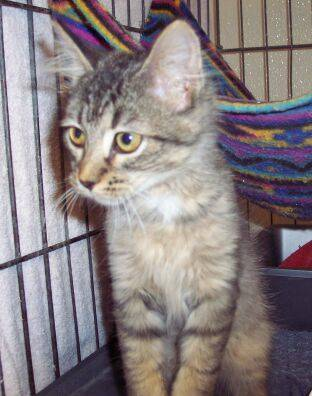

In [3]:
Image(filename='data/MobileNet-samples/cat.2.jpg')

In [4]:
preprocessed_image = prepare_image('cat.2.jpg')
predictions = mobile.predict(preprocessed_image)
result = imagenet_utils.decode_predictions(predictions)
print(result)

[[('n02123045', 'tabby', 0.49299264), ('n02124075', 'Egyptian_cat', 0.46253404), ('n02123159', 'tiger_cat', 0.023638811), ('n02127052', 'lynx', 0.010916105), ('n02123394', 'Persian_cat', 0.006512475)]]


# Fine-tune MobileNet on sign language digits
https://github.com/ardamavi/Sign-Language-Digits-Dataset

In [10]:
os.chdir('data/Sign-Language-Digits-Dataset')
if os.path.isdir('train/0/') is False:
    os.mkdir('train')
    os.mkdir('valid')
    os.mkdir('test')
    for i in range(0,10):
        shutil.move(f'{i}', 'train')
        os.mkdir(f'valid/{i}')
        os.mkdir(f'test/{i}')

        valid_samples = random.sample(os.listdir(f'train/{i}'), 30)
        for j in valid_samples:
            shutil.move(f'train/{i}/{j}', f'valid/{i}')

        test_samples = random.sample(os.listdir(f'train/{i}'), 5)
        for k in test_samples:
            shutil.move(f'train/{i}/{k}', f'test/{i}')
os.chdir('../..')


In [12]:
train_path = 'data/Sign-Language-Digits-Dataset/train'
valid_path = 'data/Sign-Language-Digits-Dataset/valid'
test_path = 'data/Sign-Language-Digits-Dataset/test'

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=train_path, target_size=(224,224), batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=valid_path, target_size=(224,224),batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=test_path, target_size=(224,224), batch_size=10, shuffle=False)

Found 1712 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


In [13]:
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes

# Modify Model

In [14]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [16]:
def count_params(model):
    non_trainable_params = np.sum([np.prod(v.get_shape().as_list()) for v in model.non_trainable_weights])
    trainable_params = np.sum([np.prod(v.get_shape().as_list()) for v in model.trainable_weights])
    return {'non_trainable_params': non_trainable_params, 'trainable_params': trainable_params}

params = count_params(mobile)
assert params['non_trainable_params'] == 21888
assert params['trainable_params'] == 4231976
x = mobile.layers[-6].output
output = Dense(units=10, activation='softmax')(x)
model = Model(inputs=mobile.input, outputs=output)
for layer in model.layers[:-23]:
    layer.trainable = False

model.summary()



Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128   

In [17]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x=train_batches, validation_data=valid_batches, epochs=10,verbose=2)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 172 steps, validate for 30 steps
Epoch 1/10
172/172 - 31s - loss: 0.8674 - accuracy: 0.7442 - val_loss: 1.5531 - val_accuracy: 0.5200
Epoch 2/10
172/172 - 30s - loss: 0.1185 - accuracy: 0.9866 - val_loss: 1.0529 - val_accuracy: 0.6133
Epoch 3/10
172/172 - 32s - loss: 0.0422 - accuracy: 0.9988 - val_loss: 0.8550 - val_accuracy: 0.6933
Epoch 4/10
172/172 - 30s - loss: 0.0220 - accuracy: 1.0000 - val_loss: 0.7672 - val_accuracy: 0.7100
Epoch 5/10
172/172 - 30s - loss: 0.0146 - accuracy: 1.0000 - val_loss: 0.6997 - val_accuracy: 0.7467
Epoch 6/10
172/172 - 30s - loss: 0.0104 - accuracy: 1.0000 - val_loss: 0.6503 - val_accuracy: 0.7633
Epoch 7/10
172/172 - 34s - loss: 0.0078 - accuracy: 1.0000 - val_loss: 0.6402 - val_accuracy: 0.7633
Epoch 8/10
172/172 - 30s - loss: 0.0061 - accuracy: 1.0000 - val_loss: 0.6132 - val_accuracy: 0.7767
Epoch 9/10
172/172 - 31s - loss: 0.0048 - accuracy: 1.0000 - val_loss: 0.5971 - val_accuracy: 0.780

In [18]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks =np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max()/2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i,j],
                 horizontalalignment="center",
                 color="white" if cm[i,j]>thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

predictions = model.predict(x=test_batches, verbose=0)
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions,axis=1))

print(test_batches.class_indices)



{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9}


Confusion matrix, without normalization
[[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 2 3 0 0 0 0 0 0 0]
 [0 0 2 0 0 3 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0]
 [0 0 1 0 0 0 0 4 0 0]
 [0 0 0 0 0 0 0 0 4 1]
 [0 0 0 0 0 0 0 0 0 5]]


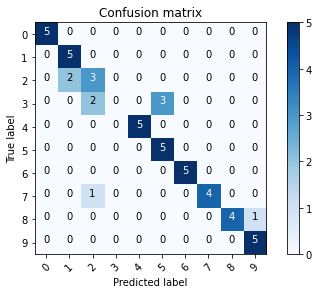

In [19]:
cm_plot_labels = ['0','1','2','3','4','5','6','7','8','9']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion matrix')
